<a href="https://colab.research.google.com/github/sangramkesharidash/Google-Colab-files/blob/main/EQUITYDATA_Screener_EDA_PE_RSI_PS_Quartiles_Compare_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

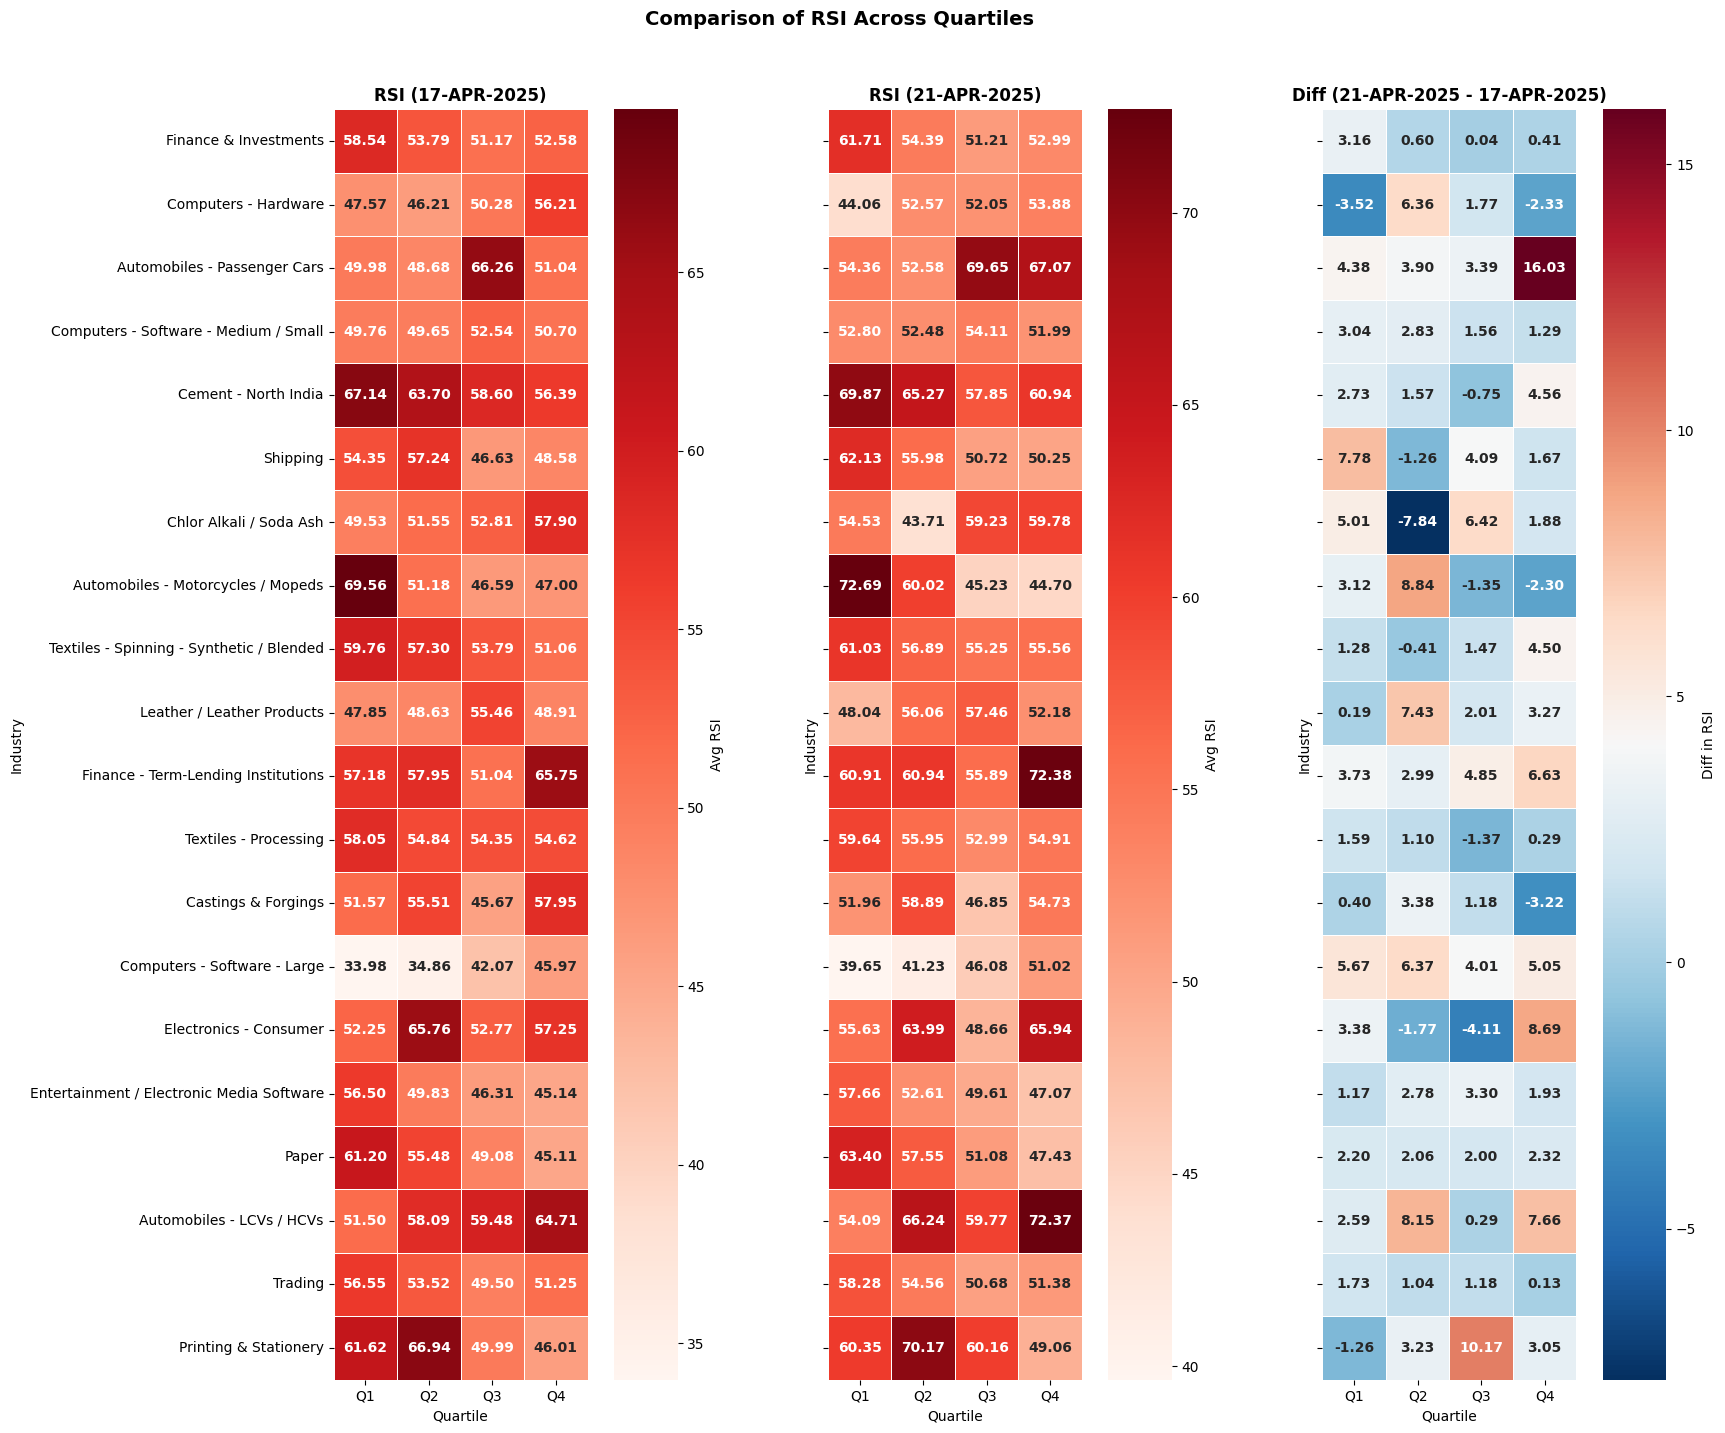

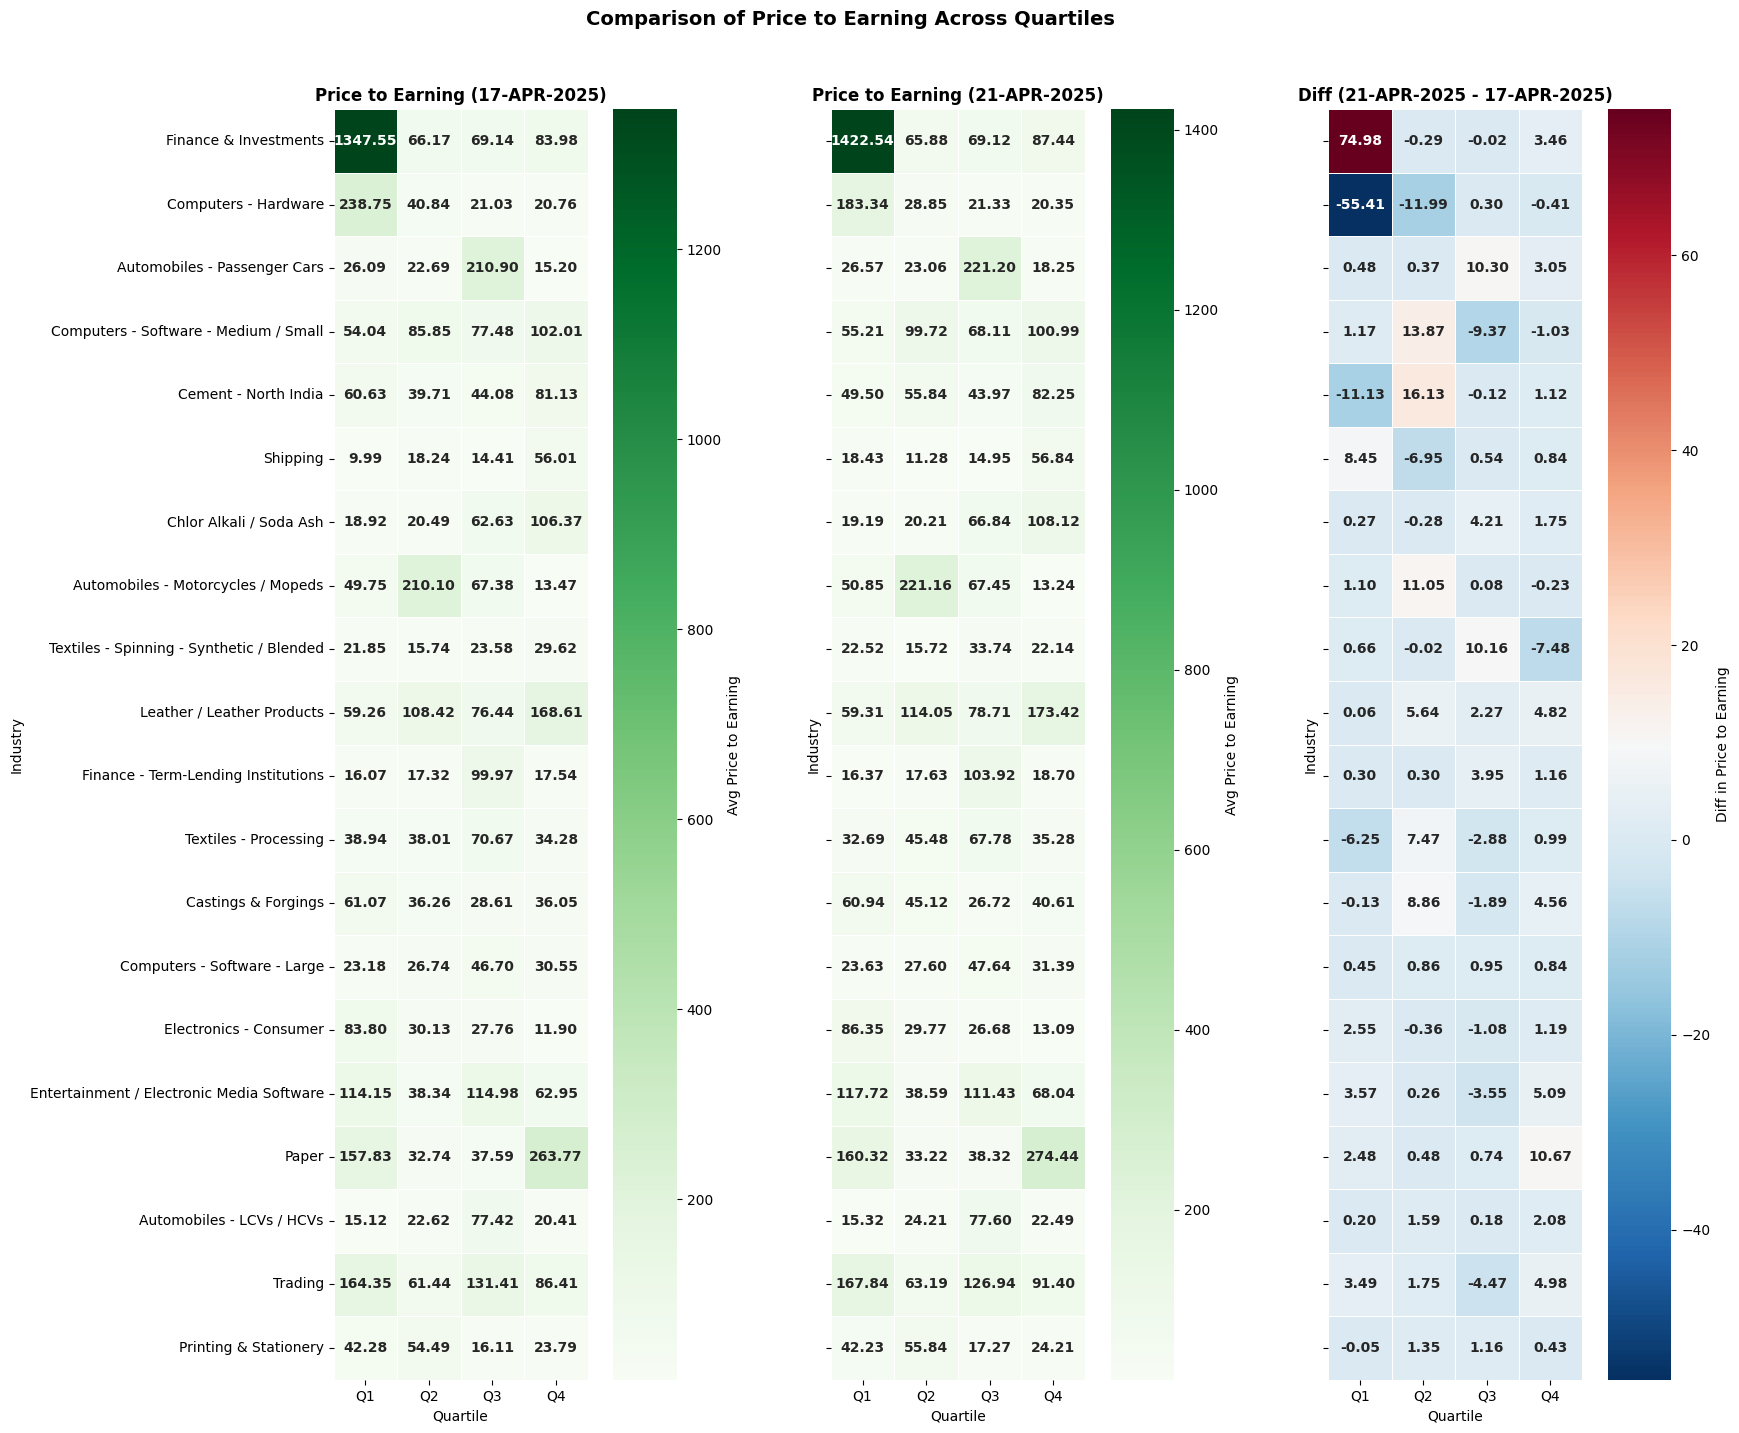

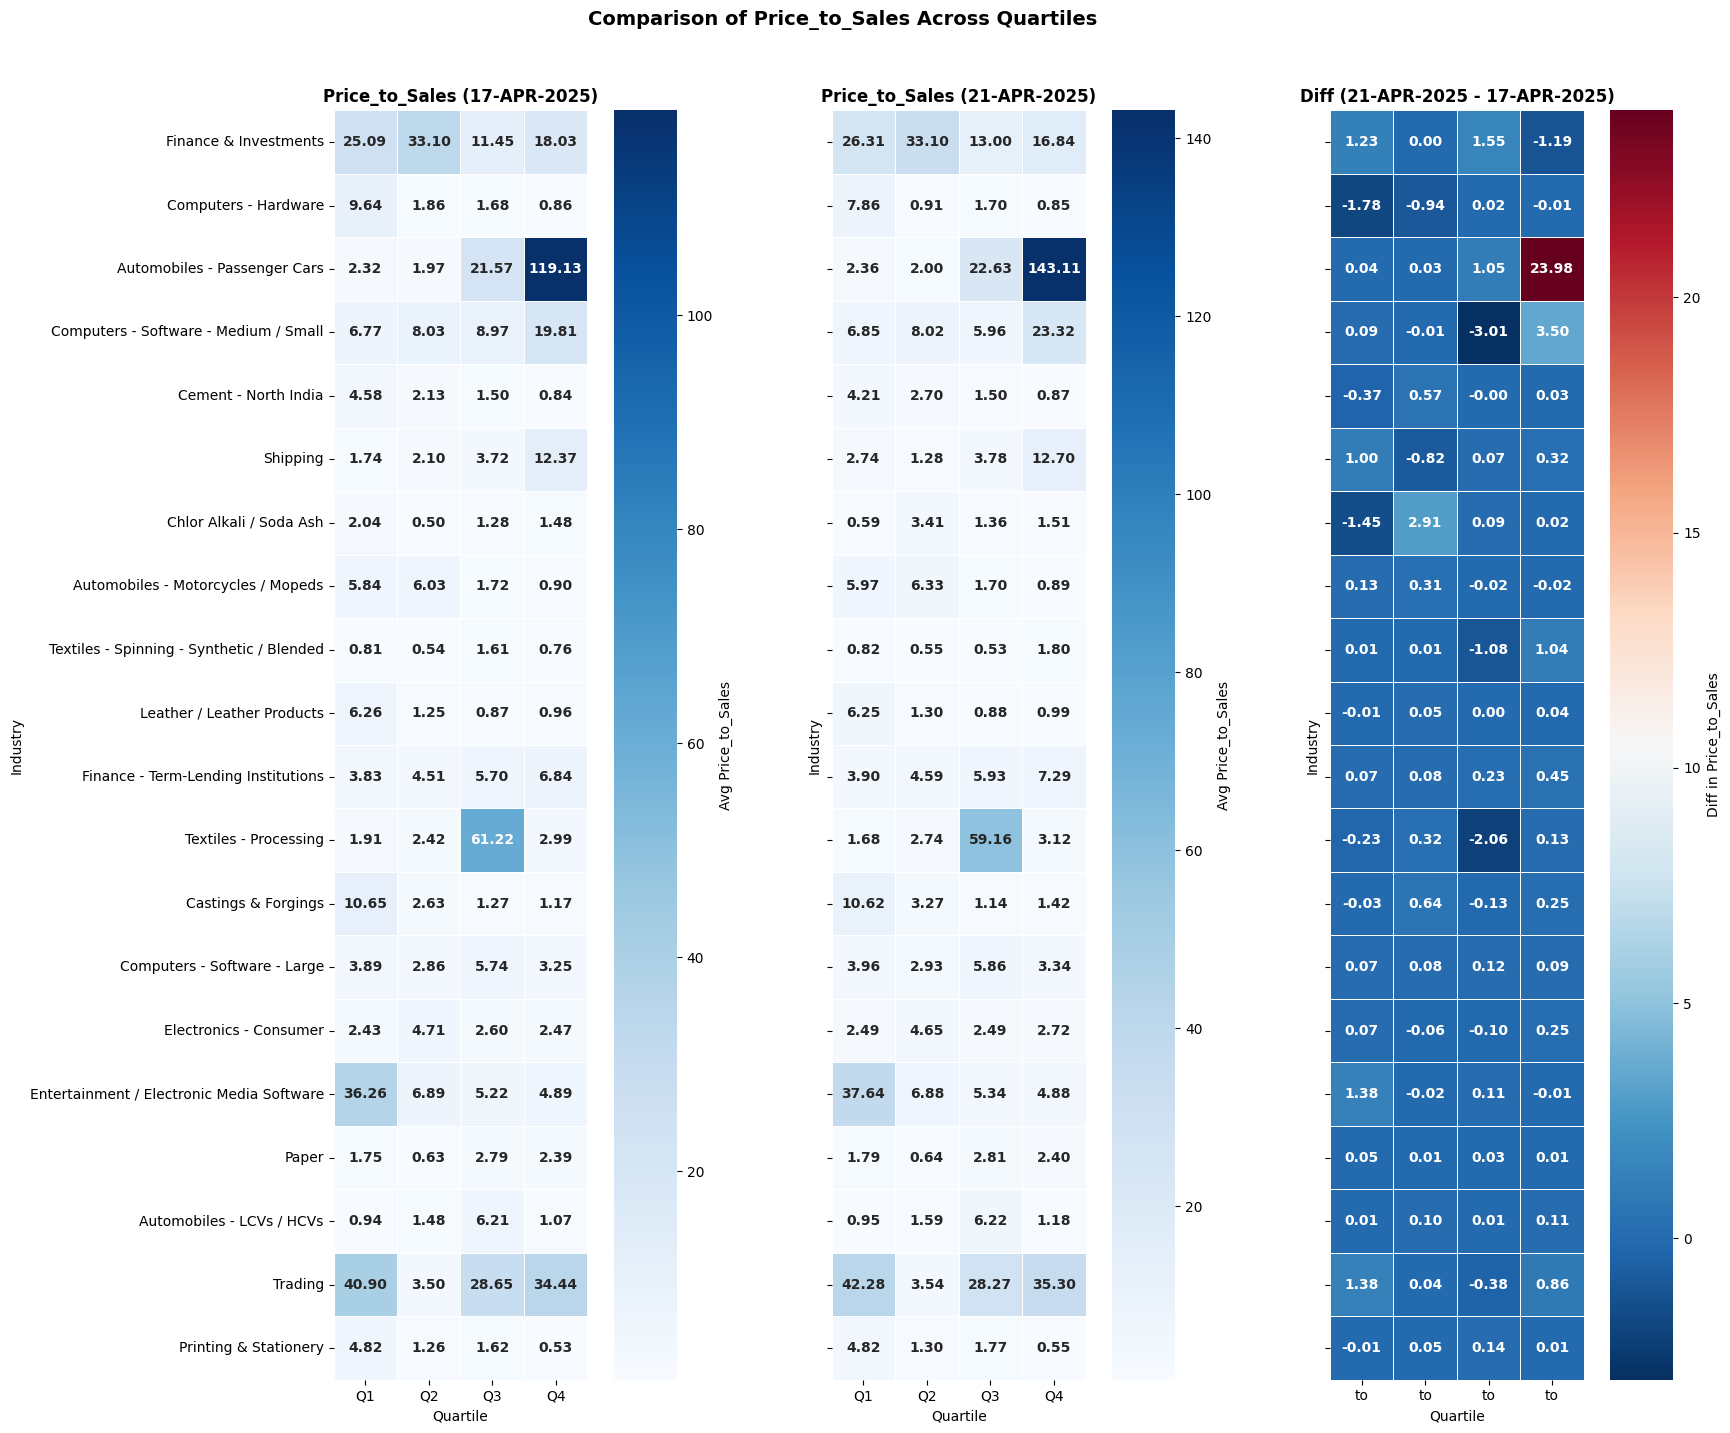

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# File paths and output
file_path_current = '/content/drive/My Drive/equitydata-screener-all-stocks/equitydata-screener-all-stocks-21-APR-2025.csv'
file_path_compare = '/content/drive/My Drive/equitydata-screener-all-stocks/equitydata-screener-all-stocks-17-APR-2025.csv'
output_dir = '/content/drive/My Drive/equitydata-screener-pe-ps-rsi-quartiles-compare'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extract dates from filenames
filename_current = os.path.basename(file_path_current)
file_prefix_current = re.search(r'-(\d{2}-[A-Z]{3}-\d{4})\.csv$', filename_current).group(1)
filename_compare = os.path.basename(file_path_compare)
file_prefix_compare = re.search(r'-(\d{2}-[A-Z]{3}-\d{4})\.csv$', filename_compare).group(1)

# Load data
df_current = pd.read_csv(file_path_current, encoding='utf-8')
df_compare = pd.read_csv(file_path_compare, encoding='utf-8')

# Validate required columns
required_columns = ['Name', 'Industry', 'Market Capitalization', 'Price to Earning', 'RSI', 'Sales', 'Price to Sales']
assert all(col in df_current.columns for col in required_columns)
assert all(col in df_compare.columns for col in required_columns)

# Calculate Price to Sales
calculate_and_verify_ps = lambda df: df.assign(
    Price_to_Sales=df.apply(lambda row: row['Market Capitalization'] / row['Sales'] if row['Sales'] != 0 else None, axis=1)
)
df_current = calculate_and_verify_ps(df_current)
df_compare = calculate_and_verify_ps(df_compare)

# Clean data
def clean_data(df):
    cols = ['Name', 'Industry', 'Market Capitalization', 'Price to Earning', 'RSI', 'Sales', 'Price_to_Sales']
    df_clean = df[cols].copy()
    for col in cols[2:]:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    return df_clean.dropna()

df_clean_current = clean_data(df_current)
df_clean_compare = clean_data(df_compare)

# Compute quartile metrics
def compute_quartile_metrics(df):
    results = []
    for industry, group in df.groupby('Industry'):
        group_sorted = group.sort_values('Market Capitalization', ascending=False)
        n = len(group_sorted)
        if n < 4: continue
        sizes = [n // 4 + (1 if i < n % 4 else 0) for i in range(4)]
        indices = [(sum(sizes[:i]), sum(sizes[:i+1])) for i in range(4)]
        for q, (start, end) in enumerate(indices, 1):
            subset = group_sorted.iloc[start:end]
            for metric in ['RSI', 'Price to Earning', 'Price_to_Sales']:
                results.append({
                    'Industry': industry,
                    'Quartile': f'Q{q}',
                    'Metric': metric,
                    'Average': subset[metric].mean()
                })
    return pd.DataFrame(results)

quartile_metrics_current = compute_quartile_metrics(df_clean_current)
quartile_metrics_compare = compute_quartile_metrics(df_clean_compare)

# Quartile differences
def calculate_quartile_differences(current_df, compare_df):
    movements, differences = [], []
    industries = set(current_df['Industry']).intersection(compare_df['Industry'])
    metrics, quartiles = ['RSI', 'Price to Earning', 'Price_to_Sales'], ['Q1', 'Q2', 'Q3', 'Q4']
    for industry in industries:
        move_row, diff_row, total = {'Industry': industry}, {'Industry': industry}, 0
        for m in metrics:
            for q in quartiles:
                cur = current_df[(current_df['Industry'] == industry) & (current_df['Metric'] == m) & (current_df['Quartile'] == q)]['Average']
                com = compare_df[(compare_df['Industry'] == industry) & (compare_df['Metric'] == m) & (compare_df['Quartile'] == q)]['Average']
                if not cur.empty and not com.empty:
                    diff = cur.iloc[0] - com.iloc[0]
                    move_row[f'{m}_{q}'] = abs(diff)
                    diff_row[f'{m}_{q}'] = diff
                    total += abs(diff)
                else:
                    move_row[f'{m}_{q}'] = 0
                    diff_row[f'{m}_{q}'] = 0
        move_row['Total_Movement'] = total
        movements.append(move_row)
        differences.append(diff_row)
    return pd.DataFrame(movements).sort_values('Total_Movement', ascending=False), pd.DataFrame(differences)

movement_df, difference_df = calculate_quartile_differences(quartile_metrics_current, quartile_metrics_compare)

movement_df.to_csv(os.path.join(output_dir, f'{file_prefix_current}_quartile_movement.csv'), index=False)
difference_df.to_csv(os.path.join(output_dir, f'{file_prefix_current}_quartile_difference.csv'), index=False)

# Heatmap prep
prepare_heatmap_data = lambda df, m: df[df['Metric'] == m].pivot(index='Industry', columns='Quartile', values='Average').reindex(columns=['Q1', 'Q2', 'Q3', 'Q4']) if 'Quartile' in df.columns else df.set_index('Industry')[[f'{m}_Q{i}' for i in range(1,5)]].rename(columns=lambda x: x.split('_')[1])

# Plot heatmap
def plot_side_by_side_heatmap(compare_data, current_data, diff_data, metric, top_industries, title, filename):
    cmap_dict = {'RSI': 'Reds', 'Price to Earning': 'Greens', 'Price_to_Sales': 'Blues'}
    cmap_main, cmap_diff = cmap_dict.get(metric, 'viridis'), 'RdBu_r'
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 14), sharey=True)
    sns.heatmap(compare_data.loc[top_industries], annot=True, fmt='.2f', cmap=cmap_main, ax=ax1, square=True,
                cbar_kws={'label': f'Avg {metric}'}, linewidths=0.5, annot_kws={'size': 10, 'weight': 'bold'})
    ax1.set_title(f'{metric} ({file_prefix_compare})', fontsize=12, fontweight='bold')
    sns.heatmap(current_data.loc[top_industries], annot=True, fmt='.2f', cmap=cmap_main, ax=ax2, square=True,
                cbar_kws={'label': f'Avg {metric}'}, linewidths=0.5, annot_kws={'size': 10, 'weight': 'bold'})
    ax2.set_title(f'{metric} ({file_prefix_current})', fontsize=12, fontweight='bold')
    sns.heatmap(diff_data.loc[top_industries], annot=True, fmt='.2f', cmap=cmap_diff, ax=ax3, square=True,
                cbar_kws={'label': f'Diff in {metric}'}, linewidths=0.5, annot_kws={'size': 10, 'weight': 'bold'})
    ax3.set_title(f'Diff ({file_prefix_current} - {file_prefix_compare})', fontsize=12, fontweight='bold')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('Quartile')
        ax.set_ylabel('Industry')
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
    plt.show()

# Generate heatmaps
metrics = ['RSI', 'Price to Earning', 'Price_to_Sales']
top_industries = movement_df['Industry'].head(20)
for metric in metrics:
    compare_heatmap_data = prepare_heatmap_data(quartile_metrics_compare, metric)
    current_heatmap_data = prepare_heatmap_data(quartile_metrics_current, metric)
    diff_heatmap_data = prepare_heatmap_data(difference_df, metric)
    plot_side_by_side_heatmap(compare_heatmap_data, current_heatmap_data, diff_heatmap_data,
                              metric, top_industries,
                              f'Comparison of {metric} Across Quartiles',
                              f'{file_prefix_current}_heatmap_comparison_{metric}.png')
